In [1]:
import sys

import torch_geometric.transforms

sys.path.append('../')

import random
from incidence_graph import IncidenceGraph
import multignn
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import s2ag
import scipy.stats as stats
import numpy as np


%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

device = torch.device(f'cuda:4' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'Available memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 3 - torch.cuda.memory_allocated(device) / 1024 ** 3:.2f} GB')

Using device: cuda:4
Available memory: 15.75 GB


In [2]:
random.seed(0)
G = s2ag.generate(MAX_SIZE=100000, P=0.5)
print(f'Graph shape: {G.shape()}')
data = []
for _, val_mask in G:
    data.append(0 if val_mask is None else val_mask)
Y = torch.tensor(data, dtype=torch.float32).view(-1, 1)

Populating graph (papers: 1300, authors: 2402, queue: 9421): : 100819it [12:35, 133.51it/s]                                                                               

Graph shape: [2406, 9203, 17987, 23662, 22290, 15146, 7275, 2350, 459, 41]


In [58]:
random.seed(0)
MAX_DIM_ZEROED = 3
PROPORTION = 0.3
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2

total_size = sum([G.size(i) for i in range(MAX_DIM_ZEROED)])
zero_out = random.sample(list(range(total_size)), int(total_size * PROPORTION))
N = len(zero_out)
X = Y.clone().detach().to(device=device, dtype=torch.float32)
X[zero_out] = 0

train_mask = zero_out[:int(N * TRAIN_SIZE)]
val_mask = zero_out[int(N * TRAIN_SIZE):int(N * (TRAIN_SIZE + VAL_SIZE))]
test_mask = zero_out[int(N * (TRAIN_SIZE + VAL_SIZE)):]

In [91]:
def train(SEED, D, EPOCHS, LOGGING, A_SIZE, LAYERS=1):
    random.seed(SEED)
    torch.random.manual_seed(SEED)
    A = G.sparse_matrices(neighbor_dists=[], rel_dims=range(-1, -A_SIZE, -1))
    for i in range(len(A)):
        A[i] = A[i].to(device=device)
    layers = []
    for i in range(LAYERS):
        in_d = 1 if i == 0 else D
        output_func = nn.Linear(D, 1) if i == LAYERS - 1 else None
        layers.append(multignn.MultiGraphLayer(vertex_agg_func=multignn.sparse_vertex_agg,
                                               graph_agg_func=multignn.LinearGraphAggregate(len(A), in_d, D, activation_func=nn.LeakyReLU(), use_bias=True),
                                               update_func= multignn.LinearMessageUpdate(in_d, D, D, activation_func=nn.LeakyReLU(), use_bias=True),
                                               output_func=output_func))
    model = multignn.PartialForwardNN(*layers).to(device=device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.L1Loss()
    print(sum(sum(p for p in param.size()) for param in model.parameters()))
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    tr_losses = []
    val_losses = []

    it = range(EPOCHS)
    if LOGGING == 0:
        it = tqdm(it, desc='Training')
    elif LOGGING == 1:
        print('Epoch #: Train Loss, Validation Loss, Validation Accuracy')

    for epoch in it:
        opt.zero_grad()
        output = model.forward(X, A).to(device='cpu')
        loss = loss_func(output[train_mask], Y[train_mask])
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())

        with torch.no_grad():
            output = model.forward(X, A)[val_mask].to(device='cpu')
            val_loss = loss_func(output, Y[val_mask])
            val_losses.append(val_loss.item())
            #sched.step(val_loss)

        if LOGGING == 1:
            print(f'Epoch {epoch + 1:4}\t{loss.item():.8f}\t{val_loss.item():.8f}')

        # acc, _, rel = test(model, A, logging=0)
        # if epoch % 100 == 0:
        #     print(f'Epoch {epoch + 1:4}\t{acc:.8f}\t{np.median(rel):.8f}')
        # model.train()

    if LOGGING == 0:
        it.close()

    return model, tr_losses, val_losses, A

In [37]:
def plot(tr_losses, val_losses, start=0, filename=None):
    xs = list(range(start, len(tr_losses)))
    plt.plot(xs, tr_losses[start:], label='training loss')
    plt.plot(xs, val_losses[start:], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss values from epochs {start + 1} to {len(tr_losses)}')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [6]:
def test(model, A, threshold=10, logging=1):
    model.eval()
    output = model.forward(X, A).to(device='cpu')
    abs_err = []
    rel_err = []
    for i in test_mask:
        abs_err.append(abs(output[i].item() - Y[i].item()))
        rel_err.append(abs(output[i].item() - Y[i].item()) / Y[i].item() * 100)

    if logging == 1:
        print(f'{len(abs_err)} samples in test set')
        print(f'Mean absolute error: {np.mean(abs_err)}, {np.std(abs_err)}')
        print(f'Median absolute error: {np.median(abs_err)}, {stats.iqr(abs_err)}')
        print(f'Range of absolute error: {min(abs_err)}, {max(abs_err)}')
        print(f'Mean relative error %: {np.mean(rel_err)}, {np.std(rel_err)}')
        print(f'Median relative error %: {np.median(rel_err)}, {stats.iqr(rel_err)}')
        print(f'Range of relative error %: {min(rel_err)}, {max(rel_err)}')

    acc = sum([1 if rel_err[i] < threshold else 0 for i in range(len(rel_err))]) / len(rel_err)*100
    if logging == 1:
        print(f'Accuracy: {acc}')

    return acc, abs_err, rel_err


In [38]:
def hist(data, filename=None):
    plt.hist(data, density=True)
    plt.xlabel('Relative error %')
    plt.ylabel('% of samples')
    plt.title('Relative error distribution')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [92]:
# restriction: # params < input size, D=64/17500 32/25000
model, tr_losses, val_losses, A = train(0, 8, 2500, 0, 10, 1)
_, _, rel = test(model, A)
plot(tr_losses, val_losses)
hist(rel)

Training:   0%|▏                                                                                                                         | 5/2500 [00:00<00:51, 48.53it/s]

87


Training:   6%|██████▋                                                                                                                 | 140/2500 [00:03<00:52, 44.95it/s]


KeyboardInterrupt: 

In [83]:
for max_dim in range(10):
    print(f'Max dim zeroed: {max_dim}')
    accs = []
    meds = []
    for proportion in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        random.seed(0)
        MAX_DIM_ZEROED = max_dim
        PROPORTION = proportion
        TRAIN_SIZE = 0.6
        VAL_SIZE = 0.2

        total_size = sum([G.size(i) for i in range(MAX_DIM_ZEROED + 1)])
        zero_out = random.sample(list(range(total_size)), int(total_size * PROPORTION))
        N = len(zero_out)
        X = Y.clone().detach().to(device=device, dtype=torch.float32)
        X[zero_out] = 0

        train_mask = zero_out[:int(N * TRAIN_SIZE)]
        val_mask = zero_out[int(N * TRAIN_SIZE):int(N * (TRAIN_SIZE + VAL_SIZE))]
        test_mask = zero_out[int(N * (TRAIN_SIZE + VAL_SIZE)):]

        model, tr_losses, val_losses, A = train(0, 8, 10000, -1, 10, 1)
        acc, _, rel = test(model, A, logging=0)
        accs.append(acc)
        meds.append(np.median(rel))
    print(accs)
    print(meds)

Max dim zeroed: 0
[87.5, 93.81443298969072, 91.72413793103448, 94.30051813471503, 94.6058091286307, 87.88927335640139, 97.62611275964392, 92.20779220779221, 94.45727482678984, 95.850622406639]
[2.8296400441063776, 1.9196169716971263, 1.4801279703776042, 0.8960322329872533, 0.8511543273925781, 2.6768742775430487, 1.6029198964436848, 1.5149267096268504, 0.4709157076748935, 0.9337506975446429]
Max dim zeroed: 1
[92.24137931034483, 92.25806451612904, 92.53945480631278, 93.32615715823465, 90.18087855297158, 91.67264895908112, 89.23739237392374, 88.96663078579118, 92.87081339712918, 92.24806201550388]
[1.124637881372562, 0.21265029907226565, 1.092652713551241, 0.5532809666224888, 0.8568412379214638, 0.869565691266741, 0.792229175567627, 1.1893819173177085, 0.5643226601983193, 0.8065223693847656]
Max dim zeroed: 2
[89.3581081081081, 88.42905405405406, 85.8108108108108, 85.26182432432432, 87.73648648648648, 84.09346846846847, 82.86679536679536, 83.86824324324324, 87.36861861861863, 86.23310810

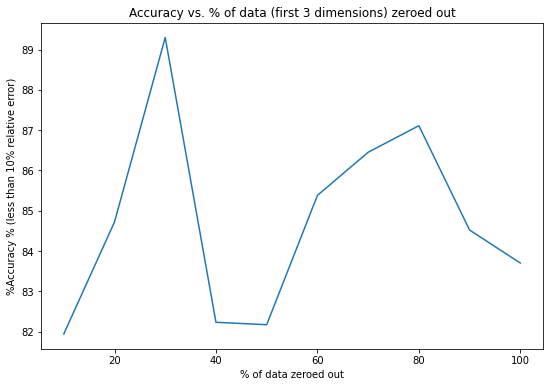

In [46]:
#D=32
# accs = [91.22,89.61, 87.05, 89.27, 85.20, 89.25, 90.44, 87.23, 87.86, 89.98]
# meds = [0.09,0.11, 0.36, 0.19, 0.24, 0.17, 0.22, 0.20, 0.27, 0.32 ]
xs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.plot(xs, accs)
plt.xlabel('% of data zeroed out')
plt.ylabel('%Accuracy % (less than 10% relative error)')
plt.title(f'Accuracy vs. % of data (first 3 dimensions) zeroed out')
plt.show()